In [1]:
import pandas as pd
import numpy as np
import os
import joblib

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score

# LOAD DATA

df = pd.read_csv("player_injury_score_2020_2025_cleaned.csv")


# SORT DATA (important for time features)
df = df.sort_values(["Name", "season"])


# CREATE NEXT SEASON TARGET

# shift games missed forward → next season injury
df["games_missed_next_season"] = (
    df.groupby("Name")["games_missed"].shift(-1)
)

# classification target
df["target"] = (df["games_missed_next_season"] >= 20).astype(int)


# DROP LAST SEASON (no future label)

df = df.dropna(subset=["games_missed_next_season"])

# FEATURES (baseline)

feature_cols = [
    "games_missed",
    "games_missed_last_season",
    "total_days_missed",
    "minor_count",
    "moderate_count",
    "severe_count",
    "has_severe_injury"
]

X = df[feature_cols].fillna(0)
y = df["target"]


# TRAIN / TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


# MODEL PIPELINE

model = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000))
])



# TRAIN MODEL
model.fit(X_train, y_train)


# EVALUATION

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

print("ROC AUC:", roc_auc_score(y_test, y_prob))


# SAVE MODEL

os.makedirs("models", exist_ok=True)

joblib.dump(model, "models/injury_clf.pkl")

print("\n Model saved → models/injury_clf.pkl")



Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.40      0.49       241
           1       0.67      0.85      0.75       345

    accuracy                           0.66       586
   macro avg       0.66      0.62      0.62       586
weighted avg       0.66      0.66      0.64       586

ROC AUC: 0.6737266221660954

 Model saved → models/injury_clf.pkl


Improved model:

In [2]:
!pip install xgboost


In [3]:
# ============================================
# XGBOOST INJURY RISK MODEL (NO DATA LEAKAGE)
# ============================================

import pandas as pd
import numpy as np
import joblib
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier


# --------------------------------------------
# 1. LOAD YOUR DATASET
# --------------------------------------------
df = pd.read_csv("player_injury_score_2020_2025_cleaned.csv")

# Clean player names (remove leading/trailing spaces)
df["Name"] = df["Name"].astype(str).str.strip()

print("Dataset shape:", df.shape)
print("\nColumns:", df.columns)


# --------------------------------------------
# 2. CLEAN DATA
# --------------------------------------------

# ensure proper datatype
df["season"] = df["season"].astype(str)

# convert severe flag to numeric if needed
if df["has_severe_injury"].dtype == bool:
    df["has_severe_injury"] = df["has_severe_injury"].astype(int)


# --------------------------------------------
# 3. SORT BY PLAYER + TIME
# (important for time-series features)
# --------------------------------------------
df = df.sort_values(["Name", "season"]).reset_index(drop=True)


# --------------------------------------------
# 4. CREATE PAST HISTORY FEATURES (LAG FEATURES)
# --------------------------------------------

# previous season days missed
df["prev_days_missed"] = df.groupby("Name")["total_days_missed"].shift(1)

# previous season severe injury
df["prev_severe"] = df.groupby("Name")["has_severe_injury"].shift(1)

# drop first season rows (no history)
df = df.dropna(subset=["prev_days_missed", "prev_severe"])

print("\nAfter lag feature creation:", df.shape)


# --------------------------------------------
# 5. CREATE TARGET VARIABLE
# --------------------------------------------
# injury = missed significant time (>15 days)
df["injury_label"] = (df["total_days_missed"] > 15).astype(int)


# --------------------------------------------
# 6. SELECT FEATURES (NO LEAKAGE)
# --------------------------------------------
features = [
    "minor_count",
    "moderate_count",
    "severe_count",
    "prev_days_missed",
    "prev_severe"
]

X = df[features]
y = df["injury_label"]

print("\nFeatures used:", features)


# --------------------------------------------
# 7. TRAIN TEST SPLIT
# --------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


# --------------------------------------------
# 8. TRAIN XGBOOST MODEL
# --------------------------------------------
model = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    eval_metric="logloss",
    random_state=42
)


model.fit(X_train, y_train)


# --------------------------------------------
# 9. EVALUATE MODEL
# --------------------------------------------
pred = model.predict(X_test)
prob = model.predict_proba(X_test)[:, 1]

print("\nClassification Report:\n")
print(classification_report(y_test, pred))

print("ROC AUC:", roc_auc_score(y_test, prob))


# --------------------------------------------
# 10. FEATURE IMPORTANCE
# --------------------------------------------
importance = pd.DataFrame({
    "feature": features,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=False)

print("\nTop Important Features:\n", importance)


Dataset shape: (3660, 15)

Columns: Index(['Name', 'season', 'minor_count', 'moderate_count', 'severe_count',
       '2020_2021', '2021_2022', '2022_2023', '2023_2024', '2024_2025',
       'has_severe_injury', 'total_days_missed', 'injury_score',
       'games_missed', 'games_missed_last_season'],
      dtype='object')

After lag feature creation: (2928, 17)

Features used: ['minor_count', 'moderate_count', 'severe_count', 'prev_days_missed', 'prev_severe']

Classification Report:

              precision    recall  f1-score   support

           0       0.62      0.70      0.65       151
           1       0.89      0.85      0.87       435

    accuracy                           0.81       586
   macro avg       0.75      0.77      0.76       586
weighted avg       0.82      0.81      0.81       586

ROC AUC: 0.8881327548146456

Top Important Features:
             feature  importance
0       minor_count    0.623365
1    moderate_count    0.215913
4       prev_severe    0.068810
2   

In [4]:
# --------------------------------------------
# 11. SAVE MODEL
# --------------------------------------------
os.makedirs("models", exist_ok=True)
joblib.dump(model, "models/injury_xgb.pkl")

print("\n✅ Model saved → models/injury_xgb.pkl")



✅ Model saved → models/injury_xgb.pkl


Predict_Refined:

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

# Load cleaned dataset
df = pd.read_csv("player_injury_score_2020_2025_cleaned.csv")

# Clean player names
df["Name"] = df["Name"].astype(str).str.strip()

# Ensure numeric
df["injury_score"] = pd.to_numeric(df["injury_score"], errors="coerce")
df["total_days_missed"] = pd.to_numeric(df["total_days_missed"], errors="coerce")

# Sort properly
df = df.sort_values(["Name", "season"]).reset_index(drop=True)

print("Dataset ready:", df.shape)


Dataset ready: (3660, 15)


In [10]:
df


,Name,season,minor_count,moderate_count,severe_count,2020_2021,2021_2022,2022_2023,2023_2024,2024_2025,has_severe_injury,total_days_missed,injury_score,games_missed,games_missed_last_season
0,(James) Mike Scott,2020_2021,1.0,3.0,0.0,39.393939,0.000000,0.0,0.0,0.0,False,27.0,NaN,13.023529,NaN
1,(James) Mike Scott,2021_2022,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,True,170.0,100.0,82.000000,13.023529
2,(James) Mike Scott,2022_2023,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,True,170.0,100.0,82.000000,82.000000
3,(James) Mike Scott,2023_2024,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,True,170.0,100.0,82.000000,82.000000
4,(James) Mike Scott,2024_2025,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,True,170.0,100.0,82.000000,82.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3655,Zylan Cheatham,2020_2021,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,True,170.0,100.0,82.000000,NaN
3656,Zylan Cheatham,2021_2022,1.0,0.0,0.0,0.000000,1.315789,0.0,0.0,0.0,False,3.0,NaN,1.447059,82.000000
3657,Zylan Cheatham,2022_2023,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,True,170.0,100.0,82.000000,1.447059
3658,Zylan Cheatham,2023_2024,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,True,170.0,100.0,82.000000,82.000000


In [11]:
# Move legacy season columns → injury_score column

season_cols = ["2020_2021", "2021_2022", "2022_2023", "2023_2024", "2024_2025"]

for col in season_cols:
    if col in df.columns:
        mask = df["season"] == col
        df.loc[mask, "injury_score"] = df.loc[mask, col]

# Remove old columns (not needed anymore)
df = df.drop(columns=[c for c in season_cols if c in df.columns], errors="ignore")

# Ensure numeric
df["injury_score"] = pd.to_numeric(df["injury_score"], errors="coerce")

print("✅ Injury scores fixed")
print(df[["Name","season","injury_score"]].head())


✅ Injury scores fixed
                 Name     season  injury_score
0  (James) Mike Scott  2020_2021     39.393939
1  (James) Mike Scott  2021_2022           NaN
2  (James) Mike Scott  2022_2023           NaN
3  (James) Mike Scott  2023_2024           NaN
4  (James) Mike Scott  2024_2025           NaN


In [12]:
model = joblib.load("models/injury_clf.pkl")  # or xgb_model.pkl if using XGBoost


In [13]:
def predict_next_season(player_name, df, model):

    player_df = df[df["Name"] == player_name].sort_values("season")

    if player_df.empty:
        print("Player not found.")
        return None

    last_row = player_df.iloc[-1]

    features = [
        "games_missed",
        "games_missed_last_season",
        "total_days_missed",
        "minor_count",
        "moderate_count",
        "severe_count",
        "has_severe_injury"
    ]

    X_input = last_row[features].values.reshape(1, -1)

    prob = model.predict_proba(X_input)[0][1]  # Probability of injury

    return prob * 100  # Convert to 0–100 score

In [14]:
def build_player_output(player_name, df, model):

    player_df = df[df["Name"] == player_name].copy()

    if player_df.empty:
        print("Player not found.")
        return None

    player_df = player_df.sort_values("season")

    # Historical scores
    table = player_df[["season", "injury_score"]].copy()

    # Predict 2025-26
    predicted_score = predict_next_season(player_name, df, model)

    future_row = pd.DataFrame({
        "season": ["2025_2026"],
        "injury_score": [predicted_score]
    })

    table = pd.concat([table, future_row], ignore_index=True)

    return table


In [15]:
def injury_frequency_text(player_df):

    avg_score = player_df["injury_score"].mean()
    severe_total = player_df["severe_count"].sum()

    if avg_score < 20:
        level = "rarely appears on injury reports"
    elif avg_score < 50:
        level = "has moderate injury frequency"
    else:
        level = "frequently appears on injury reports"

    text = f"This player {level}. Across 2020-2025, he recorded {severe_total} severe injuries."

    return text


In [16]:
def injury_percentile(player_name, df):

    avg_scores = df.groupby("Name")["injury_score"].mean()

    player_avg = avg_scores[player_name]

    percentile = (avg_scores < player_avg).mean() * 100

    return round(percentile, 2)


In [22]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_injury_trend(player_name, table):

    plt.figure(figsize=(10,5))

    # ---- Separate historical + predicted ----
    historical = table.iloc[:-1].copy()
    predicted = table.iloc[-1]

    # ---- Remove null values from historical ----
    valid_history = historical.dropna(subset=["injury_score"])

    # ===============================
    # CASE 1: Some history exists (n < 5 nulls)
    # ===============================
    if len(valid_history) > 0:

        seasons = valid_history["season"].tolist()
        scores = valid_history["injury_score"].tolist()

        # Add predicted point to connect line
        seasons.append(predicted["season"])
        scores.append(predicted["injury_score"])

        # Plot full line
        plt.plot(seasons, scores, marker='o', label="Injury Trend")

        # Highlight prediction
        plt.scatter(
            predicted["season"],
            predicted["injury_score"],
            color="red",
            s=120,
            label="Predicted Score",
            zorder=3
        )

    # ===============================
    # CASE 2: No historical data (5 null values)
    # ===============================
    else:
        print(f"⚠ {player_name} has no previous injury history.")

        plt.scatter(
            predicted["season"],
            predicted["injury_score"],
            color="red",
            s=150,
            label="Predicted Score Only"
        )

        plt.text(
            0.5, 0.5,
            "No historical injury data available",
            transform=plt.gca().transAxes,
            ha='center',
            fontsize=12
        )

    # ---- Labels ----
    plt.title(f"Injury Risk Trend — {player_name}")
    plt.xlabel("Season")
    plt.ylabel("Injury Score (0–100)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



📊 Injury Score Table:
      season  injury_score
0  2020_2021      3.030303
1  2021_2022     34.210526
2  2022_2023     29.545455
3  2023_2024     15.748031
4  2024_2025     35.000000
5  2025_2026     19.195037

📝 Injury Frequency:
This player has moderate injury frequency. Across 2020-2025, he recorded 0.0 severe injuries.

📈 Overall Injury Percentile (2020-2024):
71.31 percentile


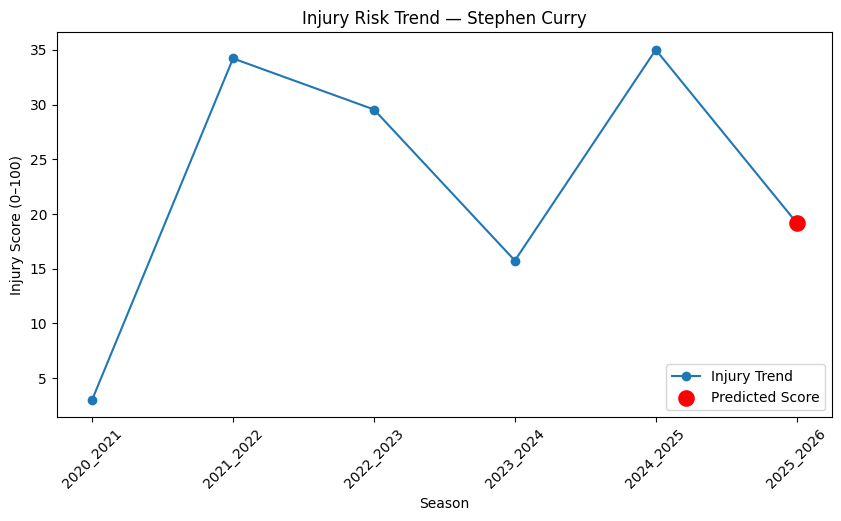

In [28]:
player_name = "Stephen Curry"

table = build_player_output(player_name, df, model)

if table is not None:

    print("\n📊 Injury Score Table:")
    print(table)

    player_df = df[df["Name"] == player_name]

    print("\n📝 Injury Frequency:")
    print(injury_frequency_text(player_df))

    print("\n📈 Overall Injury Percentile (2020-2024):")
    print(f"{injury_percentile(player_name, df)} percentile")

    plot_injury_trend(player_name, table)
